In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import time
%matplotlib inline 

plt.style.use('ggplot')
from mpl_toolkits import mplot3d

from collections import Counter
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from string import ascii_uppercase

## Data Pre-Processing 

In [4]:
def mean_var(x): 
    '''Returns mean and variance of a set x'''
    ##Calculate avg, use axis=0 to take it along the values, not the features
    mu = np.mean(x,axis=0)
    std = np.std(x,axis=0)
    return mu,std

def normalize(train,test): 
    '''Function calling both testing and training sets, 
    must be normalized by the mean and variance
    Normalize such that X = (X - mean)/sqrt(Var)'''
    ##Call the mean_var function
    mu,std = mean_var(train)
    ##Normalize
    train_norm = (train - mu)/(np.sqrt(std) +1e-15) ## 1e-15 added to avoid divide by 0 error
    test_norm = (test - mu)/(np.sqrt(std) +1e-15)
    return train_norm,test_norm


def add_bias(X): 
    '''Adds a bias term if need be, will need for logistic regression'''
    X_ones = np.ones(X.shape[0])
    X_ones = X_ones.reshape(-1,1)
    return np.append(X_ones,X,axis=1)

def ohe(y): 
    '''One-hot-encoder vector labels 
    Uses sklearn preprocess package
    Dont ask me how it works it just does'''
    label = preprocessing.LabelBinarizer()
    label.fit(y)
    y_ohe = label.transform(y)
    return np.array(y_ohe)

def digit_conv(y): 
    LETTERS = {letter: index for index, letter in enumerate(ascii_uppercase, start=0)} 
    numbers = [int(LETTERS[character]) for character in y if character in LETTERS]
    return numbers

def accuracy(ypred, yexact):
    p = np.array(ypred == yexact, dtype = int)
    return np.sum(p)/float(len(yexact))

In [5]:
pwd = '/Users/offic/repositories/ml_capstone/final_proj/12.Letter-Recognition'

test, train = pd.read_csv(pwd+'/test.csv'),pd.read_csv(pwd+"/train.csv")
##The first column of the set is the label, based on the discription doc 
y_test, y_train = test.iloc[:,0].values, train.iloc[:,0].values 
x_test,x_train = test.iloc[:,1:].values,train.iloc[:,1:].values

##The ohe is coded to handle non-numbers so we're good on that front. 
##no need to code it 
y_test_ohe,y_train_ohe = ohe(y_test),ohe(y_train)

##We also need to normalize the features and then add bais for the logistic regression model
##normalizing is not needed for all methods tho, only for our knn and logreg
x_train_norm, x_test_norm = normalize(x_train,x_test)
x_test_norm_bias, x_train_norm_bias = add_bias(x_test_norm), add_bias(x_train_norm)

In [239]:
x_test.shape

(599, 16)

0.006055858727746654


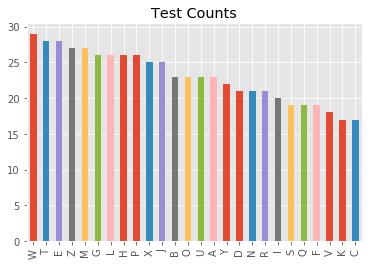

0.0028035854575498174


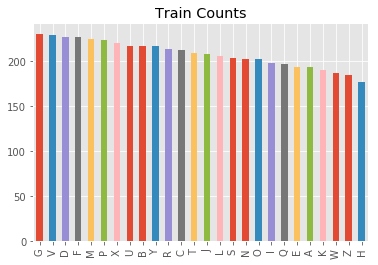

In [18]:
pd.Series(y_test).value_counts().plot('bar')
plt.title('Test Counts')
print(pd.Series(y_test).value_counts().std()/y_test.shape[0])
plt.show()

pd.Series(y_train).value_counts().plot('bar')
plt.title('Train Counts')
print(pd.Series(y_train).value_counts().std()/y_train.shape[0])
plt.show()

In [167]:
y_train_num = digit_conv(y_train)
y_test_num = digit_conv(y_test) ##Done so we can compare outputs that are digits from the log reg and knn

## Logistic Regression 

In [6]:
def predictor(X, c):
    ''' sigmoid function'''
    return 1.0/(1.0 + np.exp(-X.dot(c)))

def loss(y_exact, y_pred):
    return (-y_exact.T.dot(np.log(y_pred+1e-15))- (1.0 - y_exact).T.dot(np.log(1-y_pred+1e-15)))/float(len(y_exact))

def gradient_descent(X, y, epochs=1000, learning_rate=0.01):
    '''
        Input
        -----
        X: training features (normalized and having bias)
        y: labels
        
        output
        ------
        c: optimal coeffs
        loss_history
    '''
    loss_history = [0]*epochs
    c_dim = X.shape[1]
    n_samples = X.shape[0]
    c = np.ones((c_dim, 1))

    for epoch in range(epochs):
        y_pred = predictor(X, c)
        
        loss_history[epoch] = loss(y_pred, y).ravel()[0] # (2D) (1,1) -> 1D
                                                               # [5] -> 5
       
        XT = X.T
        gradient = XT.dot(y_pred-y)/float(n_samples)   
        # updating coeffs upon the gradient change
        c = c - learning_rate*gradient
    return c, loss_history

def plot_loss(loss):
    import matplotlib  # import package
    import matplotlib.pyplot as plt # import library pytlot and change its name to plt
    %matplotlib inline  
    plt.xlabel('# of epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.show()  
       
def multilabel_train(X, y, intr = 1500, learning_r = .1):# y_train: one_hot_encoder labels
    # y_train will have 3 columns
    c_list = []
    for i in range(y.shape[1]): 
        y_one_column = y[:, i].reshape(-1, 1) # pick ith columns
        c_one_column, loss_history = gradient_descent(X, y_one_column, epochs=intr, learning_rate=learning_r)
        #plot_loss(loss_history)
        c_list.append(c_one_column)
    return c_list


def multilabel_prediction(c_list, X):
    i = 0
    for c in c_list:
        probability = predictor(X, c) # decision score
        # probabily of one column
        if i == 0:
            probability_matrix = probability
        else:
            # combine all decision columns to form a matrix
            probability_matrix = np.concatenate(
                              (probability_matrix, probability),
                               axis=1)
        i += 1
    labels = np.r_[0:26]
    n_samples = X.shape[0]
    # find which index gives us the highest probability
    y_pred = np.zeros(n_samples, dtype=int) 
    for i in range(n_samples):
        y_pred[i] = labels[np.argmax(probability_matrix[i,:])]
    return y_pred, probability_matrix

In [8]:
eval_lst = []

for i in range(3):
    for j in range(5):
        epochs = (j+2)*500
        l_r = (i+1)*.1
        
        c_list = multilabel_train(x_train_norm_bias, y_train_ohe,intr = epochs, learning_r = l_r)
        lg_labels,prob_matrix_lg = multilabel_prediction(c_list, x_test_norm_bias)
        acc = accuracy(lg_labels,digit_conv(y_test))
        
        eval_lst.append((acc,epochs,l_r))

In [9]:
eval_lst.sort(key=lambda tup: tup[0]) ##Sorts tuple of values and returns the one with the largest oob
eval_lst[-1] ##So this is our best method. Use this as our actual rf classifier 

(0.7145242070116862, 2500, 0.30000000000000004)

In [10]:
start = time.time()
c_list = multilabel_train(x_train_norm_bias, y_train_ohe,intr = 2500, learning_r = .3)
lg_labels,prob_matrix_lg = multilabel_prediction(c_list, x_test_norm_bias)
time_lg = abs(start - time.time()) 
print(time_lg) 

18.50147247314453


## Random Forest

In [173]:
## In order to do the optimization, we have to have an accuracy/evalutation function
## Because of the way random forests are formatted we can just use the oob error to pick our optimal value

methods = ['auto','sqrt','log2']
score = []

for i in range(8): 
    n = (i+1)*50
    for m in methods:
        classifier = RandomForestClassifier(n_estimators=n, max_features=m,oob_score=True,random_state=0)
        classifier.fit(x_train,y_train.ravel())
        score.append((classifier.oob_score_,m,n))

In [174]:
score.sort(key=lambda tup: tup[0]) ##Sorts tuple of values and returns the one with the largest oob
score[-1] ##So this is our best method. Use this as our actual rf classifier 

(0.9333209853676607, 'log2', 300)

In [175]:
start = time.time()
rf_classifier = RandomForestClassifier(n_estimators=300, max_features='log2',random_state=0)
rf_classifier.fit(x_train,y_train.ravel())
rf_labels = rf_classifier.predict(x_test)
time_rf = abs(start - time.time()) 
print(time_rf) 

4.609849214553833


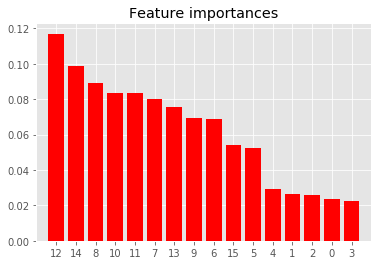

In [176]:
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(x_test.shape[1]), importances[indices],
       color="r", align="center")
plt.xticks(range(x_test.shape[1]), indices)
plt.xlim([-1, x_test.shape[1]])
plt.show()

## K-NN

In [17]:
def KNN(x,p,k,metric): 
    '''x->full set to calucate distance to 
    p->point to calculate distance from 
    k->number of nearest neighbors 
    
    K ponts with the shortest distance between them and the point p
    
    Uses eucludian distance to calculate distance between the set and a new point
    Returns the K 
    For-Loop not used because np will less compulationally expensive'''
    if metric == 'euclid':
        diff = (x-p)**2 ##This shouldn't work in lin alg, but it's fine in numpy
        ##It's equvilent to subtracting the row for each n, then squaring each term
        dist = np.sqrt(np.sum(diff, axis = 1))
    if metric == 'matthattan': 
        dist = np.sum(abs(x - p),axis = 1 )
    if metric == 'chebyshev': 
        dist = np.max(abs(x - p), axis = 1)
    ##Pick out the k nearest points 
    return np.argpartition(dist,k)[:k]

def pre_labels(x,y,p,k,metric): 
    '''x: points, y:labels
    p: point to predict
    k: # of nearest neighbors you're predicting off 
    
    Returns label of point
    '''
    ##Get knn for a point 
    k_nn = KNN(x,p,k,metric)
    ##Get labels for the k_nn 
    labels_k_nn = y[k_nn].ravel() ##array flattned with ravel
    ##Returning most common label
    ##Use Counter function from collections 
    ##Documentation here: https://docs.python.org/2/library/collections.html#collections.Counter
    
    return Counter(labels_k_nn).most_common(1)[0][0]

def pre_labels_array(x,y,test,k,metric):
    '''Return labels for a full array'''
    labels = []
    for p in test:
        labels.append(pre_labels(x,y,p,k,metric))
    return np.array(labels)


In [18]:
## We need to pick the best k. Can do this with a loop and a basic accuracy measurement. Full auc and such can be computed later.
eval_lst = []

acc_euc_lst = []
acc_mat_lst = []
acc_che_lst = []

metric_lst = ['euclid','matthattan','chebyshev']
for n in range(1,41):
    for m in metric_lst:
        labels = pre_labels_array(x_train_norm,y_train,x_test_norm, n, metric = m)
        acc_val = accuracy(labels,y_test)
        eval_lst.append((acc_val,n,m))
        if m == 'euclid':
            acc_euc_lst.append(acc_val)
        if m == 'matthattan':
            acc_mat_lst.append(acc_val)
        if m == 'chebyshev':
            acc_che_lst.append(acc_val)

In [19]:
eval_lst.sort(key=lambda tup: tup[0])
print(eval_lst[-1]) ##Oh no 

(0.9248747913188647, 2, 'euclid')


Text(0.5, 0, 'N')

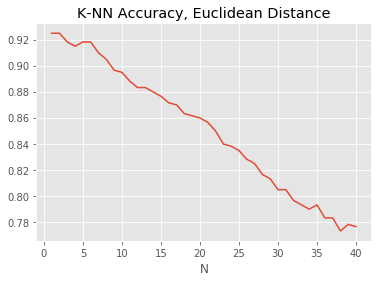

In [21]:
plt.plot(np.r_[1:41],acc_euc_lst)
plt.title('K-NN Accuracy, Euclidean Distance')
plt.xlabel('N')

Text(0.5, 0, 'N')

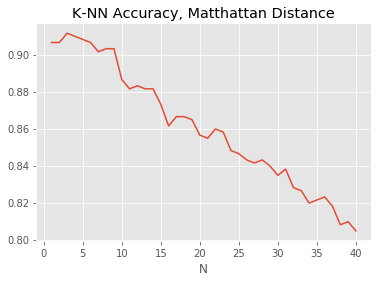

In [22]:
plt.plot(np.r_[1:41],acc_mat_lst)
plt.title('K-NN Accuracy, Matthattan Distance')
plt.xlabel('N')

Text(0.5, 0, 'N')

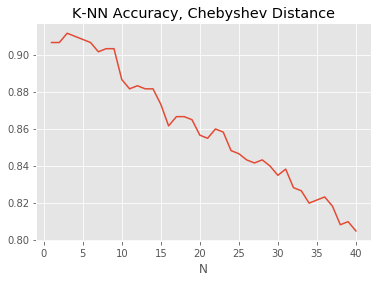

In [23]:
plt.plot(np.r_[1:41],acc_mat_lst)
plt.title('K-NN Accuracy, Chebyshev Distance')
plt.xlabel('N')

In [375]:
start = time.time()
knn_labels = pre_labels_array(x_train_norm,y_train,x_test_norm, 2, metric = 'euclid')
time_knn = abs(start - time.time()) 
print(time_knn) 

0.2682640552520752
P


## Evaluation

Text(0.5, 0.92, 'Train Set, with no classification')

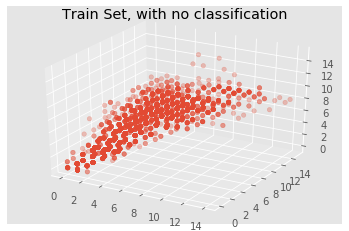

In [388]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_train[:,0],x_train[:,1],x_train[:,3], alpha =.3, cmap = 'viridis')
plt.title("Train Set, with no classification")

Text(0.5, 0.92, 'Test Set, with Test Labels')

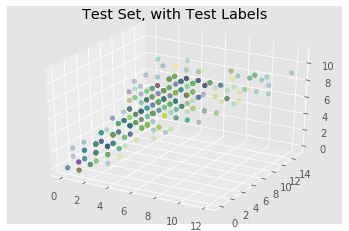

In [212]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_test[:,0],x_test[:,1],x_test[:,3], alpha =.3, c=digit_conv(y_test), cmap = 'viridis')
plt.title("Test Set, with Test Labels")

Text(0.5, 0.92, 'Test Set, Classified with Logistic Regression')

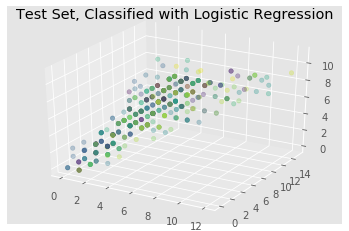

In [391]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_test[:,0],x_test[:,1],x_test[:,3], alpha =.3, c=y_pred_lg, cmap = 'viridis')
plt.title("Test Set, Classified with Logistic Regression")

Text(0.5, 0.92, 'Test Set, Classified with Random Forests')

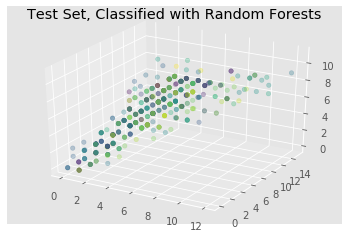

In [209]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_test[:,0],x_test[:,1],x_test[:,3], alpha =.3, c=digit_conv(rf_labels), cmap = 'viridis')
plt.title("Test Set, Classified with Random Forests")

Text(0.5, 0.92, 'Test Set, Classified with K-NN')

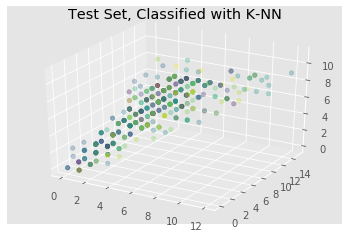

In [377]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_test[:,0],x_test[:,1],x_test[:,3], alpha =.3, c=digit_conv(knn_labels), cmap = 'viridis')
plt.title("Test Set, Classified with K-NN")

In [25]:
## Accuracy Measure 
#print('KNN:',accuracy(knn_labels,y_test))
#print('RF:',accuracy(rf_labels,y_test))
print('LR:',accuracy(lg_labels,digit_conv(y_test)))

LR: 0.7145242070116862


In [26]:
## F_1
def f1(pres, recall): 
    return 2*(pres*recall)/(pres+recall)

## LogReg AUC

In [27]:
def predict_binary_label(score, threshold):
    label = np.copy(score)
    label[label >= threshold] = 1
    label[label < threshold] = 0
    return label

def get_confusion_matrix(predictor_score, true_labels):
    '''
        true_lables: binary labels (0 and 1)
    '''
    # step1 change threshold from 1 to 0
    # step2 get predicted labels
    # step3 compare pred ones to true ones -> TN, TF, FN, FP
    TNR_list = []
    TPR_list = []
    FNR_list = []
    FPR_list = []
    for i in range(100, -1, -1):
        threshold = i/100;
        pred_labels = predict_binary_label(predictor_score, threshold)
        # compare between pred_labels and true_labels
        #use np.logical_and to calculate
        TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0)) 
        FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0)) 
        FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1)) 
        TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1)) 
        TNR = TN/(TN+FP)
        FPR = FP/(TN+FP)
        FNR = FN/(FN+TP)
        TPR = TP/(FN+TP)
        TNR_list.append(TNR)
        FPR_list.append(FPR)
        FNR_list.append(FNR)
        TPR_list.append(TPR)
    return TNR_list, FPR_list, FNR_list, TPR_list


def plot_ROC_curve(FPR_list, TPR_list):
    plt.plot(FPR_list, TPR_list, color='g', lw=2) # roc curve
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # diagonal line
    plt.xlim([0, 1.01]) # set the limits of x-axis
    plt.ylim([0, 1.01]) # set the limiets of y-axis
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')    
#     plt.legend(loc="lower right")
    plt.show()

def ROC_curve(FPR_list, TPR_list):
    '''
        convert the rates to the staircase effect
    '''
    FPR_ROC = []
    TPR_ROC = []
    for i in range(len(FPR_list)-1):
        FPR_ROC.append(FPR_list[i])
        TPR_ROC.append(TPR_list[i])
        FPR_ROC.append(FPR_list[i+1])
        TPR_ROC.append(TPR_list[i])
    return FPR_ROC, TPR_ROC # get staircase


def AUC(FPR_ROC, TPR_ROC):
    area = 0.0
    for i in range(len(FPR_ROC)-1):
        area += TPR_ROC[i]*(FPR_ROC[i+1] - FPR_ROC[i])    
    return area

In [28]:
auc_lst = []
f1_lst = []
for i in range(25): 
    TNR_list, FPR_list, FNR_list, TPR_list = get_confusion_matrix(prob_matrix_lg[:, i], y_test_ohe[:, i])
    FPR_ROC, TPR_ROC = ROC_curve(FPR_list, TPR_list) 
    auc_lst.append(AUC(FPR_ROC, TPR_ROC))
    
    pres = sum(TPR_list)/(sum(TPR_list)+sum(FPR_list))
    recall = sum(TPR_list)/(sum(TPR_list)+sum(FNR_list))
    f1_lst.append(f1(pres,recall))
    
print('lg_auc:',sum(auc_lst)/len(auc_lst))
print('lg_f1:',sum(f1_lst)/len(f1_lst))

lg_auc: 0.9165805427788214
lg_f1: 0.5696734555854471


## RF AUC

In [221]:
## Using sklearn 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
print('rf_auc:',roc_auc_score(ohe(y_test),ohe(rf_labels)))
print('rf_f1:',f1_score(ohe(y_test),ohe(rf_labels), average = 'macro'))

rf_auc: 0.9564699481728733
rf_f1: 0.9146326951374646


## KNN AUC 

In [223]:
def get_predictor_scores_knn(X_train, y_train, X_test, k):
    '''
        y_train: one_hot_encoder format
    '''
    n_test_samples = X_test.shape[0]
    y_pred = []
    n_classes= y_train.shape[1]
    probability_matrix = np.zeros((n_test_samples, n_classes))
    for i in range(n_test_samples):
        test_point = X_test[i]
        k_NN_indices = KNN(X_train, test_point, k)
        k_NN_labels = y_train[k_NN_indices]
        for class_id in range(n_classes):
            ohe_labels = k_NN_labels[:, class_id]
            num_zeros = (ohe_labels == 0).sum()
            num_ones =  (ohe_labels == 1).sum()
            probability_matrix[i, class_id] = num_ones/(num_zeros + num_ones)
    return probability_matrix

def predict_binary_label(score, threshold):
    label = np.copy(score)
    label[label >= threshold] = 1
    label[label < threshold] = 0
    return label

In [383]:
probability_matrix_knn = get_predictor_scores_knn(x_train_norm, y_train_ohe, x_test_norm, 2)

In [384]:
auc_lst = []
f1_lst = []
for i in range(25): 
    TNR_list, FPR_list, FNR_list, TPR_list = get_confusion_matrix(probability_matrix_knn[:, i], y_test_ohe[:, i])
    FPR_ROC, TPR_ROC = ROC_curve(FPR_list, TPR_list) 
    auc_lst.append(AUC(FPR_ROC, TPR_ROC))
    
    pres = sum(TPR_list)/(sum(TPR_list)+sum(FPR_list))
    recall = sum(TPR_list)/(sum(TPR_list)+sum(FNR_list))
    f1_lst.append(f1(pres,recall))
    
print('knn_auc:',sum(auc_lst)/len(auc_lst))
print('knn_f1:',sum(f1_lst)/len(f1_lst))

knn_auc: 0.9581611379326448
knn_f1: 0.9386735006712797
